In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Methods

* Load & Clean Data – Ensure consistency between datasets
* Merge Data – If necessary, combine age, educational attainment and type of residence (ie urban or rural) information
* Exploratory Data Analysis (EDA) – Calculate mean prevalence per age-gender group and educational attainment
* Visualizations – Use bar plots, line plots, and heatmaps
* Statistical Analysis (ANOVA & Tukey HSD) – Validate group differences

In [27]:
df_main  = pd.read_csv('Malaria screener.csv')
df_age  = pd.read_csv('Malaria screener age.csv')

In [28]:
# Merge datasets (if necessary)
if 'ID' in df_main.columns and 'ID' in df_age.columns:
    df = pd.merge(df_main, df_age, on='ID', how='inner')  # Merge on ID
else:
    df = pd.concat([df_main, df_age], axis=1)  # Merge by column order

In [29]:
# Select relevant columns
selected_columns = ['Age of household head','Type of place of residence','Educational attainment', 'Malaria_Prevalence_2020']

# Check for missing values in the selected columns
missing_values = df[selected_columns].isnull().sum()
df = df[selected_columns].dropna()

# Display summary of the cleaned dataset
df.describe(), missing_values

(       Age of household head  Type of place of residence  \
 count             567.000000                  567.000000   
 mean               44.366843                    1.611993   
 std                12.992774                    0.487726   
 min                16.000000                    1.000000   
 25%                35.000000                    1.000000   
 50%                43.000000                    2.000000   
 75%                53.000000                    2.000000   
 max                98.000000                    2.000000   
 
        Educational attainment  Malaria_Prevalence_2020  
 count              567.000000               567.000000  
 mean                 2.989418                 0.271636  
 std                  1.500257                 0.128614  
 min                  0.000000                 0.052831  
 25%                  2.000000                 0.184202  
 50%                  3.000000                 0.259956  
 75%                  4.000000             

In [30]:
# Create Age Groups
age_bins = [15, 20, 30, 40, 50, 60, 70, 100]
age_labels = ['16-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']
df['Age_Group'] = pd.cut(df['Age of household head'], bins=age_bins, labels=age_labels, right=False)

In [31]:
# Compute mean malaria prevalence for each group
grouped_data = df.groupby(['Age_Group', 'Type of place of residence','Educational attainment'])['Malaria_Prevalence_2020'].mean().reset_index()
grouped_data.rename(columns={'Malaria_Prevalence_2020': 'Average_Prevalence'}, inplace=True)
print("\nSummary Statistics:\n", grouped_data)


Summary Statistics:
    Age_Group  Type of place of residence  Educational attainment  \
0      16-20                           1                       0   
1      16-20                           1                       1   
2      16-20                           1                       2   
3      16-20                           1                       3   
4      16-20                           1                       4   
..       ...                         ...                     ...   
79       71+                           2                       1   
80       71+                           2                       2   
81       71+                           2                       3   
82       71+                           2                       4   
83       71+                           2                       5   

    Average_Prevalence  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..         

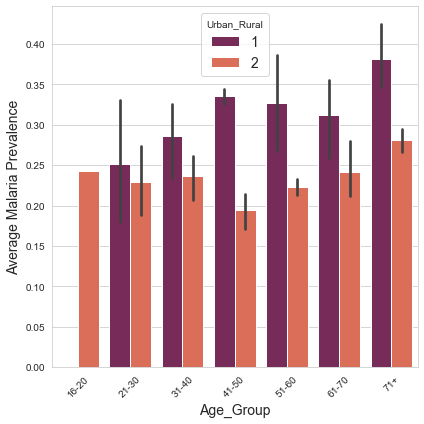

In [33]:
# Visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, y='Average_Prevalence', x='Age_Group', hue= 'Type of place of residence', palette='rocket')
#plt.title('Malaria Prevalence Trends')
plt.xlabel('Age_Group', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  Malaria prevalence trends across age and urban-rural differences

* The bar and line plots reveal age groups with higher prevalence.
* Differences between urban and rural prevalence are visualized.
* 1 = urban; 2 = rural

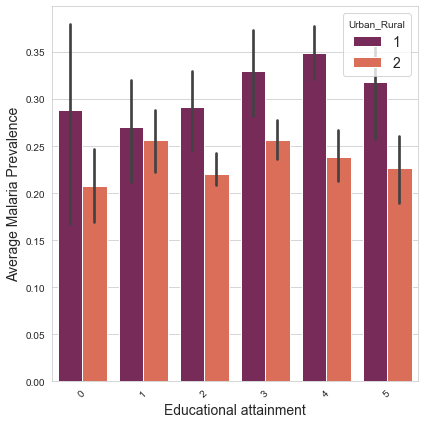

In [34]:
# Visualizations
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
sns.barplot(data=grouped_data, y='Average_Prevalence', x='Educational attainment', hue= 'Type of place of residence', palette='rocket')
#plt.title('Malaria Prevalence Trends Across')
plt.xlabel('Educational attainment', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    Malaria prevalence trends across Educational attainment and urban-rural differences

* The bar and line plots reveal education level with higher prevalence.
* Differences between urban and rural prevalence are visualized.
* 0 = No education; 1 = Incomplete primary; 2 = Complete primary; 3 = Incomplete secondary; 4 = Complete secondary; 5 = Higher 

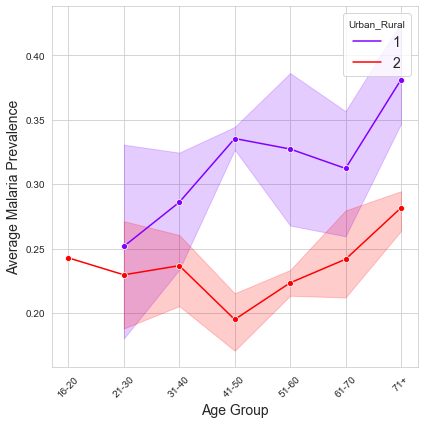

In [48]:
plt.figure(figsize=(6, 6))
sns.lineplot(data=grouped_data, x='Age_Group', y='Average_Prevalence', hue='Type of place of residence', marker='o', palette='rainbow')
#plt.title('Trends in Malaria Prevalence')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

     Trends in Malaria Prevalence by Age and Type of place of residence

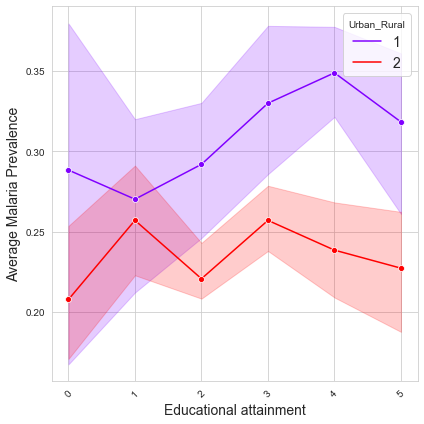

In [50]:
plt.figure(figsize=(6, 6))
sns.lineplot(data=grouped_data, x='Educational attainment', y='Average_Prevalence', hue='Type of place of residence', marker='o', palette='rainbow')
#plt.title('Trends in Malaria Prevalence')
plt.xlabel('Educational attainment', fontsize=14)
plt.ylabel('Average Malaria Prevalence', fontsize=14)
plt.legend(title='Urban_Rural', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  Trends in Malaria Prevalence by Age and Educational attainment

ANOVA Results

* Tests if malaria prevalence differs significantly across age, type of place of residence and educational attainment.
* A p-value < 0.05 suggests significant differences.

In [37]:
# ANOVA Test
anova_data = df.groupby(['Age_Group', 'Educational attainment', 'Type of place of residence'])['Malaria_Prevalence_2020']
groups = [values for (_, _, _), values in anova_data]

f_stat, p_value = f_oneway(*groups)
print("\nANOVA Results:")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4e}")

if p_value < 0.05:
    print("Statistically significant differences exist Urban_Rural differences.")
else:
    print("No significant differences found.")


ANOVA Results:
F-statistic: 2.6350, P-value: 2.6684e-09
Statistically significant differences exist Urban_Rural differences.


Tukey HSD (Post-Hoc Test)

* Identifies which specific groups are significantly different.
* The heatmap visualizes these differences.

In [38]:
# Post-Hoc Analysis (Tukey HSD)

df['Group_Label'] = df['Age_Group'].astype(str) + ", " + df['Type of place of residence'].astype(str) + ", " + df['Educational attainment'].astype(str)
tukey = pairwise_tukeyhsd(df['Malaria_Prevalence_2020'], df['Group_Label'], alpha=0.05)
print("\nTukey HSD Results:\n", tukey)


Tukey HSD Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
16-20, 2, 3 21-30, 1, 3   0.0016    0.9 -0.4219   0.425  False
16-20, 2, 3 21-30, 1, 4    0.088    0.9 -0.2943  0.4702  False
16-20, 2, 3 21-30, 1, 5  -0.0626    0.9 -0.5516  0.4264  False
16-20, 2, 3 21-30, 2, 0  -0.1008    0.9 -0.5243  0.3226  False
16-20, 2, 3 21-30, 2, 1   0.0627    0.9 -0.3607  0.4862  False
16-20, 2, 3 21-30, 2, 2  -0.0361    0.9 -0.4057  0.3336  False
16-20, 2, 3 21-30, 2, 3   0.0503    0.9 -0.3152  0.4159  False
16-20, 2, 3 21-30, 2, 4   -0.036    0.9 -0.4281   0.356  False
16-20, 2, 3 21-30, 2, 5   -0.019    0.9  -0.508  0.4699  False
16-20, 2, 3 31-40, 1, 0  -0.0754    0.9 -0.6743  0.5234  False
16-20, 2, 3 31-40, 1, 1   0.0357    0.9 -0.5632  0.6346  False
16-20, 2, 3 31-40, 1, 2   0.0444    0.9 -0.5545  0.6433  False
16-20, 2, 3 31-40, 1, 3   0.0545  

* group1: First comparison group (e.g., urban, 0-5)

* group2: Second comparison group (e.g., rural, 0-5)

* meandiff: Difference in mean malaria prevalence between group1 and group2

* p-adj Adjusted p-value (If < 0.05, the difference is significant)

* lower: Lower bound of the confidence interval

* upper: Upper bound of the confidence interval

* reject: True if the difference is statistically significant, otherwise False

Significant Differences (reject = True and p-adj < 0.05):

* Groups with significant malaria prevalence differences can be identified.

* Example: If Urban, 0-5 and Rural, 0-5 have reject = True, it means Type of place of residence impacts prevalence in this age group.

Non-Significant Differences (reject = False and p-adj > 0.05):

* If a comparison has a high p-value, there is no strong evidence that malaria prevalence differs in those groups.

Effect Size (meandiff):

* Large positive values mean group1 has higher malaria prevalence.

* Large negative values mean group2 has higher malaria prevalence.

In [39]:
tukey_results = pd.DataFrame(data=tukey._results_table.data[1:], 
                             columns=tukey._results_table.data[0])

In [40]:
# Create a heatmap of p-values
tukey_pivot = tukey_results.pivot(index='group1', columns='group2', values='p-adj')

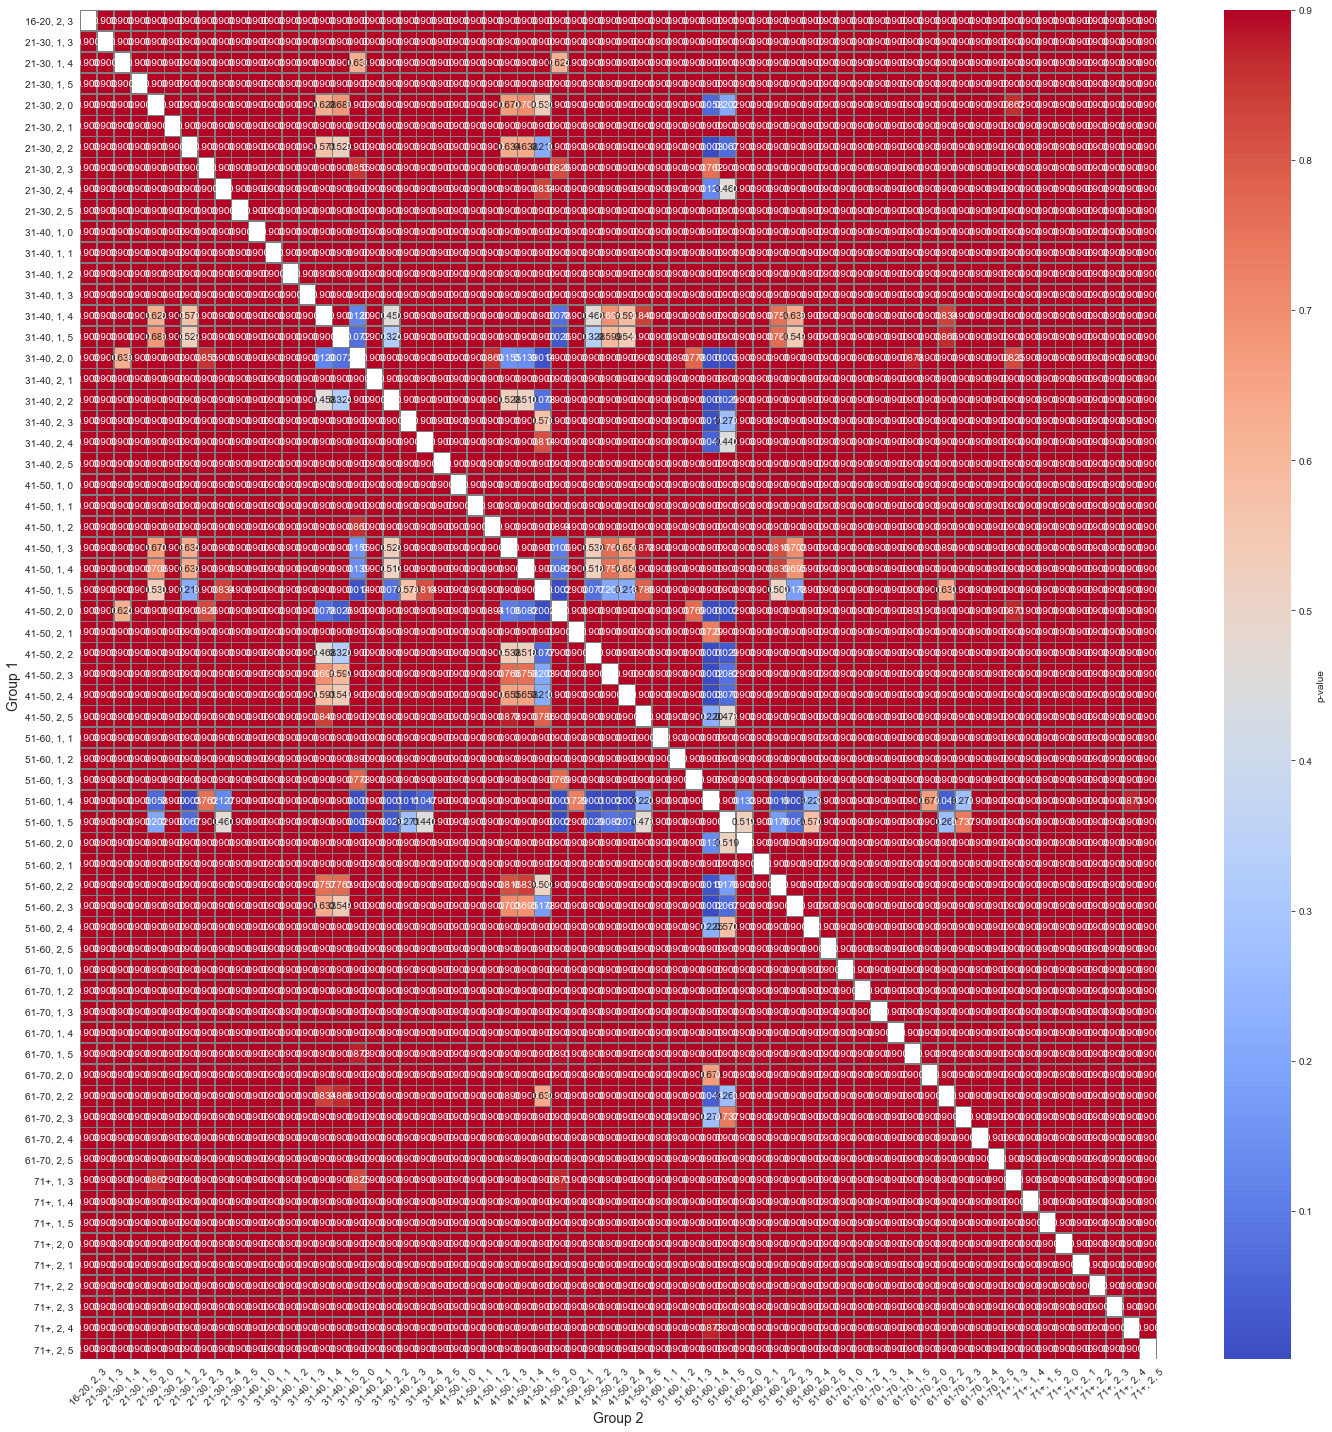

In [44]:
# Sort Tukey results for better visualization
tukey_results_sorted = tukey_results.sort_values(by=['p-adj'])

# Create a pivot table for heatmap (p-values)
tukey_pivot_pval = tukey_results.pivot(index='group1', columns='group2', values='p-adj')
tukey_pivot_meandiff = tukey_results.pivot(index='group1', columns='group2', values='meandiff')

# Ensure the heatmaps are symmetrical for better interpretation
tukey_pivot_pval = tukey_pivot_pval.combine_first(tukey_pivot_pval.T)
tukey_pivot_meandiff = tukey_pivot_meandiff.combine_first(-tukey_pivot_meandiff.T)

# Plot p-value heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(tukey_pivot_pval, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'p-value'},
            linewidths=0.5, linecolor='gray')
#plt.title('Tukey HSD - Pairwise Comparisons (p-values)')
plt.xlabel('Group 2', fontsize=14)
plt.ylabel('Group 1', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

     Tukey HSD - Pairwise Comparisons (p-values)

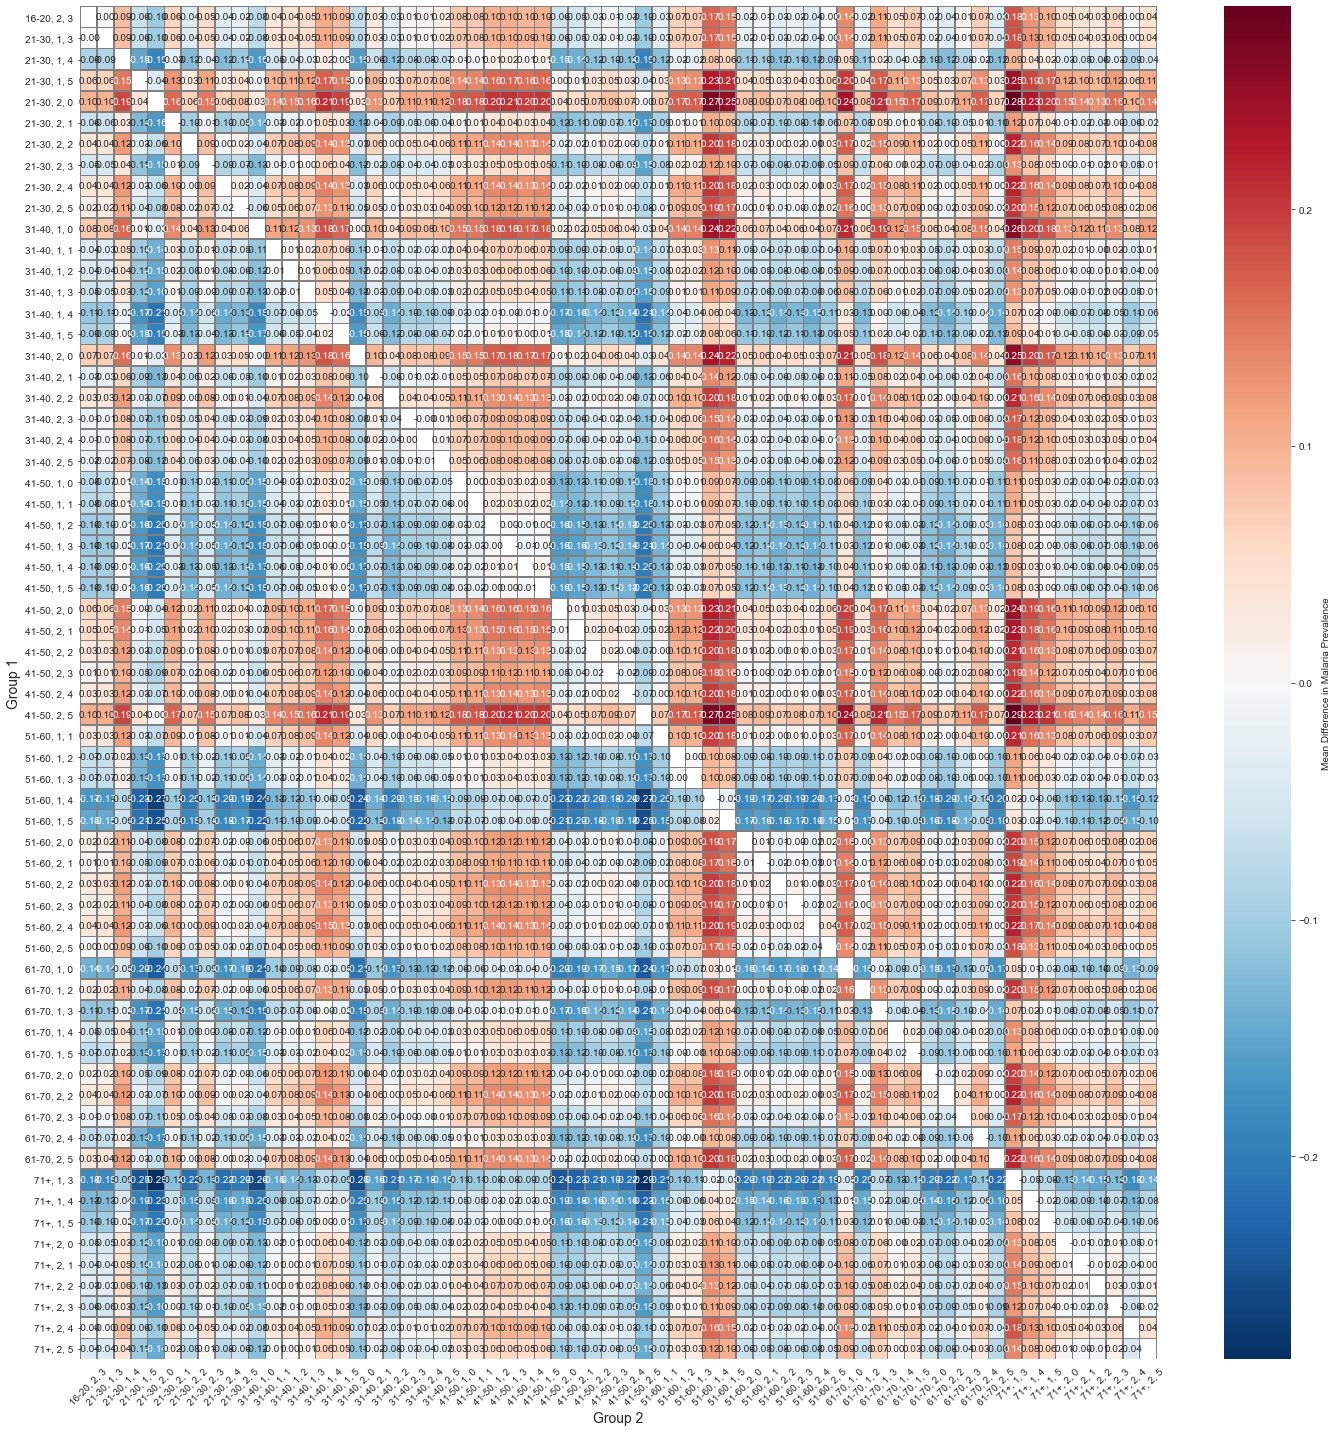

In [45]:
# Plot Mean Difference Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(tukey_pivot_meandiff, annot=True, fmt=".2f", cmap='RdBu_r', center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Mean Difference in Malaria Prevalence'})
#plt.title('Tukey HSD - Mean Differences Between Groups')
plt.xlabel('Group 2', fontsize=14)
plt.ylabel('Group 1', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

     Tukey HSD - Mean Differences Between Groups

P-Value Heatmap (Significance of Differences)

* Dark blue (low p-values) → Strong evidence of differences.
* Red/white (high p-values) → No significant difference.

Mean Difference Heatmap (Effect Size)

* Deep red values → Group 1 has much higher malaria prevalence.
* Deep blue values → Group 2 has much higher malaria prevalence.
* White (near 0) → Groups have similar prevalence.